In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from xgboost import XGBClassifier
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import cross_val_score, StratifiedKFold
import spacy

Note: you may need to restart the kernel to use updated packages.Collecting spacy
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached cloudpathlib-0.21.1-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   --- ------------------------------------ 1.3/13.9 MB 7.4 MB/s eta 0:00:02
   -------- ---------------------

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\Python312\\Scripts\\f2py.exe' -> 'c:\\Python312\\Scripts\\f2py.exe.deleteme'


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'spacy'

# Data Cleaning

In [2]:
df = pd.read_csv('steam_game_reviews.csv')

C:\Users\yapch\AppData\Local\Temp\ipykernel_32872\3356819961.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('steam_game_reviews.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review          991650 non-null  object
 1   hours_played    992153 non-null  object
 2   helpful         992153 non-null  object
 3   funny           992153 non-null  object
 4   recommendation  992153 non-null  object
 5   date            992153 non-null  object
 6   game_name       992153 non-null  object
 7   username        992072 non-null  object
dtypes: object(8)
memory usage: 60.6+ MB


In [4]:
df["hours_played"] = pd.to_numeric(df["hours_played"], errors="coerce")
df["helpful"] = pd.to_numeric(df["helpful"], errors="coerce")
df["funny"] = pd.to_numeric(df["funny"], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review          991650 non-null  object 
 1   hours_played    918437 non-null  float64
 2   helpful         989265 non-null  float64
 3   funny           991163 non-null  float64
 4   recommendation  992153 non-null  object 
 5   date            992153 non-null  object 
 6   game_name       992153 non-null  object 
 7   username        992072 non-null  object 
dtypes: float64(3), object(5)
memory usage: 60.6+ MB


In [5]:
df.dropna(inplace=True)
df.isnull().sum()

review            0
hours_played      0
helpful           0
funny             0
recommendation    0
date              0
game_name         0
username          0
dtype: int64

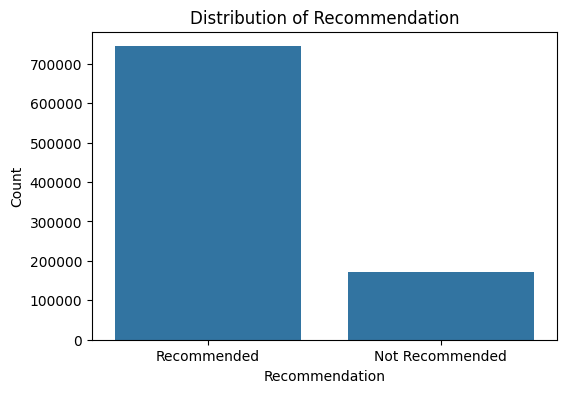

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='recommendation', data=df)
plt.title('Distribution of Recommendation')
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.show()

A subset of 100k rows of data is extracted from the dataset with the same ratio of recommended and not recommended.

In [7]:
recommended = df[df['recommendation'] == 'Recommended']
not_recommended = df[df['recommendation'] == 'Not Recommended']

n_not_recommended = 20000
n_recommended = int(n_not_recommended * 8 / 2)

sampled_recommended = recommended.sample(n=n_recommended, random_state=42)
sampled_not_recommended = not_recommended.sample(n=n_not_recommended, random_state=42)

df_sample = pd.concat([sampled_recommended, sampled_not_recommended]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sample['recommendation'].value_counts())

recommendation
Recommended        80000
Not Recommended    20000
Name: count, dtype: int64


In [ ]:
recommended = df[df['recommendation'] == 'Recommended']
not_recommended = df[df['recommendation'] == 'Not Recommended']

n_not_recommended = 20000
n_recommended = int(n_not_recommended * 8 / 2)

sampled_recommended = recommended.sample(n=n_recommended, random_state=42)
sampled_not_recommended = not_recommended.sample(n=n_not_recommended, random_state=42)

df_sample_opinion_absa = pd.concat([sampled_recommended, sampled_not_recommended]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sample_opinion_absa['recommendation'].value_counts())

# Data Preproccesing

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yapch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def preprocess_text(text):
    # 1. Text Normalization (Lowercasing)
    text = text.lower()

    # 2. Tokenization
    tokens = word_tokenize(text)

    # 3. Stopword Removal and Lemmatization
    processed_tokens = []
    for word in tokens:
        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            processed_tokens.append(lemma)

    # Join tokens back into a string
    return " ".join(processed_tokens)

In [ ]:
df_sample['processed_review'] = df_sample['review'].apply(preprocess_text)
df_sample_opinion_absa['processed_review'] = df_sample_opinion_absa['review'].apply(preprocess_text)

print("Processed Reviews:")
print(df_sample['processed_review'].head())
print("Processed Reviews for Opinion ABSA:")
print(df_sample_opinion_absa['processed_review'].head())

Processed Reviews:
0                     vvbetter valorantbetter valorant
1    game named nfs heat cell shaded map basically ...
2              great time killer especially steam deck
3    early access review thing ca wash hand really ...
4    fact game even next gen graphic pc kind insane...
Name: processed_review, dtype: object


# EDA

C:\Users\yapch\AppData\Local\Temp\ipykernel_32872\638263166.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_values.index, y=count_values.values, palette='magma')


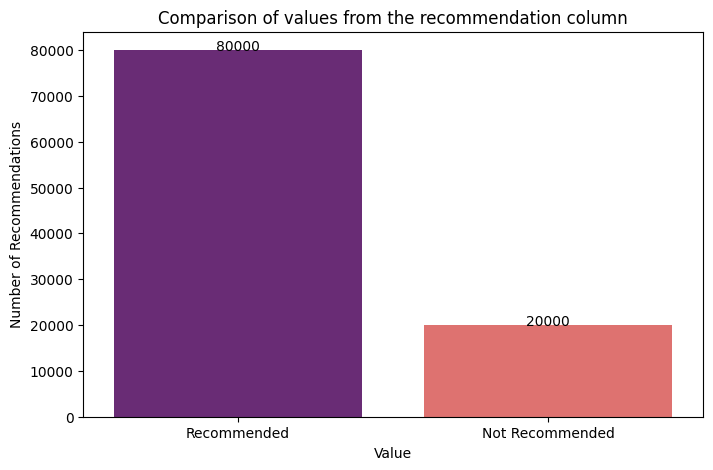

In [12]:
count_values = df_sample['recommendation'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=count_values.index, y=count_values.values, palette='magma')
plt.title('Comparison of values from the recommendation column')
plt.xlabel('Value')
plt.ylabel('Number of Recommendations')
for i, v in enumerate(count_values.values):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.show()

In [13]:
data = df_sample['date']
df2 = pd.DataFrame(data)

def preprocess_dates(date_str):
    if ',' not in date_str:
        return f"{date_str}, 2024"
    return date_str

df_sample['date'] = df_sample['date'].apply(preprocess_dates)

df_sample['date'] = pd.to_datetime(df_sample['date'], format='mixed')

df_sample['year'] = df_sample['date'].dt.year

recommendation_counts_per_year = df_sample.groupby(['year', 'recommendation']).size().unstack(fill_value=0)

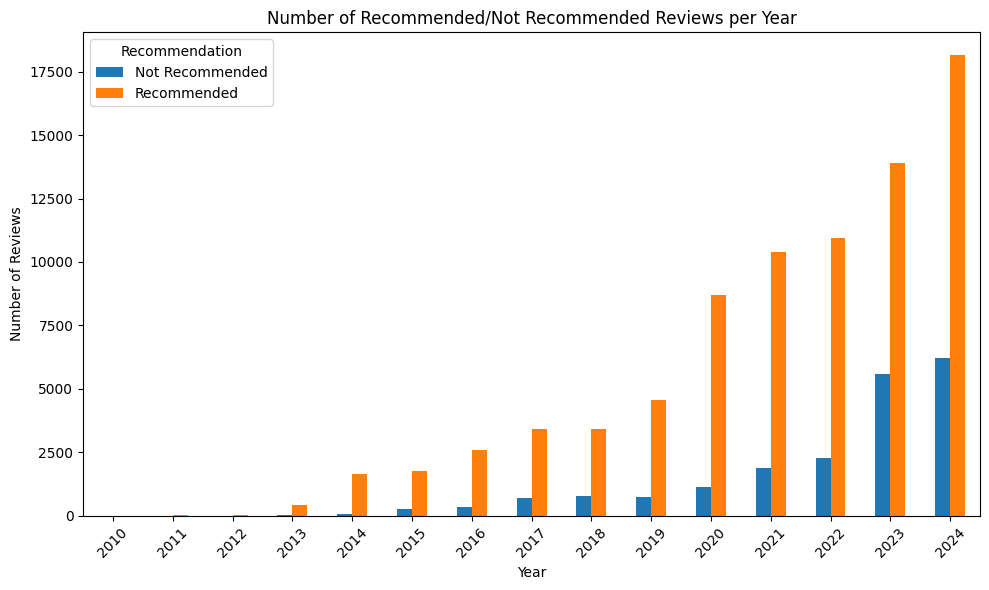

In [14]:
recommendation_counts_per_year.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Recommended/Not Recommended Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Recommendation')
plt.tight_layout()
plt.show()

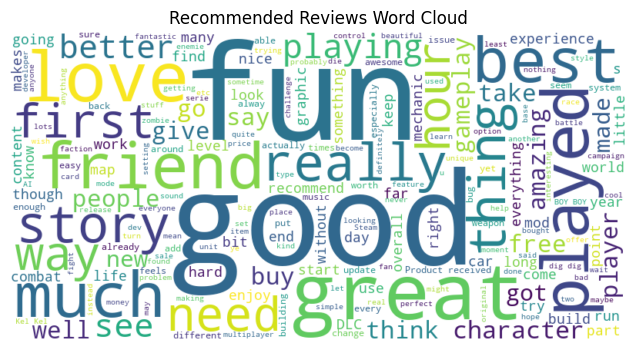

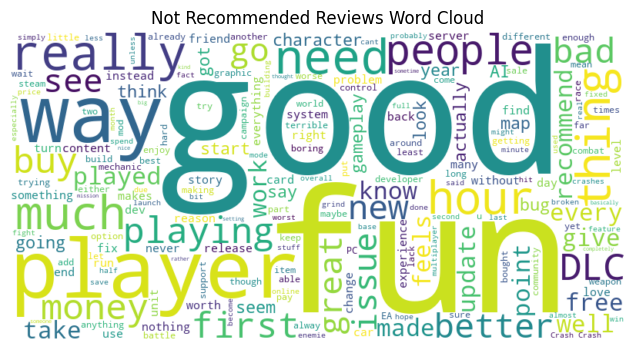

In [15]:
recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'recommended']['review'].dropna())
not_recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'not recommended']['review'].dropna())

stopwords = set(STOPWORDS)
stopwords.update(["game", "games", "play", "time", "one", "get", "early", "access", "make", "even", "review", "want", "still", "will", "feel", "lot", "now"]) # Adding specific game-related words to the list of stopwords

if len(recommended_reviews) > 0:
  wc_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Recommended Reviews Word Cloud")
  plt.imshow(wc_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
    print("No 'recommended' reviews found to generate word cloud.")

if len(not_recommended_reviews) > 0:
  wc_not_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(not_recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Not Recommended Reviews Word Cloud")
  plt.imshow(wc_not_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
  print("No 'not recommended' reviews found to generate word cloud.")

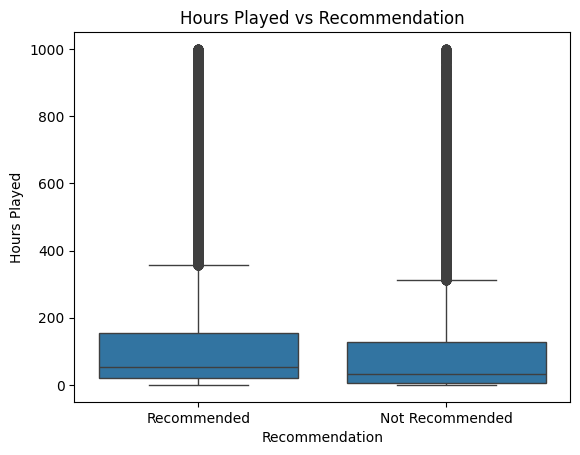

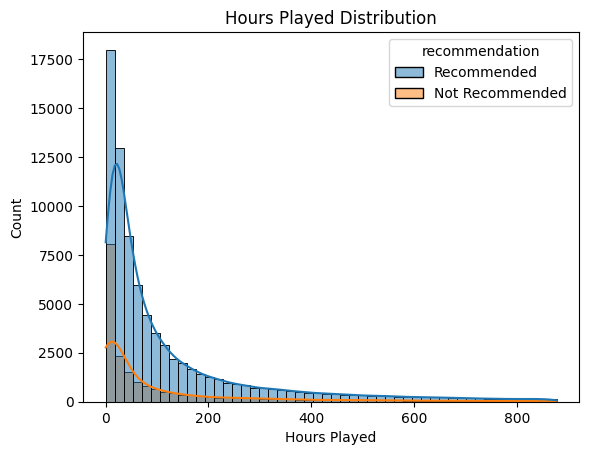

In [16]:
# Distribution of hours played for each recommendation type
sns.boxplot(data=df_sample, x='recommendation', y='hours_played')
plt.title("Hours Played vs Recommendation")
plt.xlabel("Recommendation")
plt.ylabel("Hours Played")
plt.show()

# Filter extreme outliers for better visualisation
df_filtered = df_sample[df_sample['hours_played'] < df_sample['hours_played'].quantile(0.99)]
sns.histplot(data=df_filtered, x='hours_played', hue='recommendation', kde=True, bins=50)
plt.title("Hours Played Distribution")
plt.xlabel("Hours Played")
plt.show()

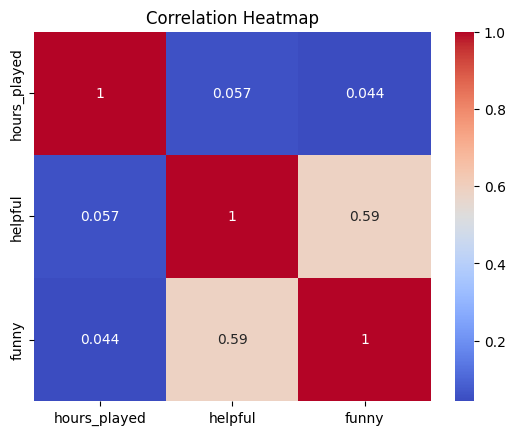

In [17]:
sns.heatmap(df_sample[['hours_played', 'helpful', 'funny']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

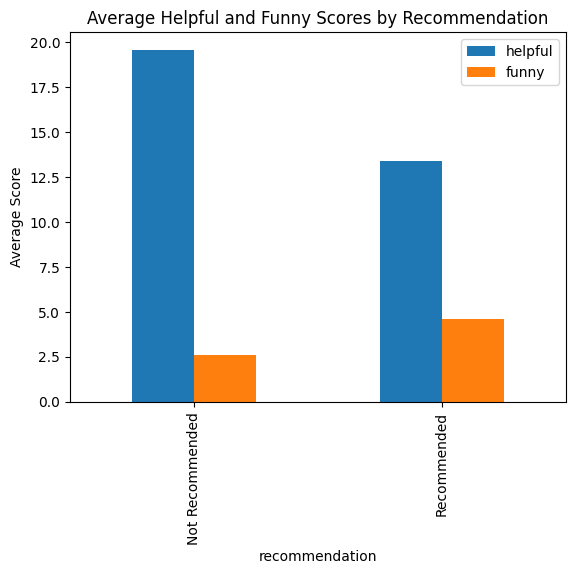

In [18]:
df_sample.groupby('recommendation')[['helpful', 'funny']].mean().plot(kind='bar')
plt.title("Average Helpful and Funny Scores by Recommendation")
plt.ylabel("Average Score")
plt.show()

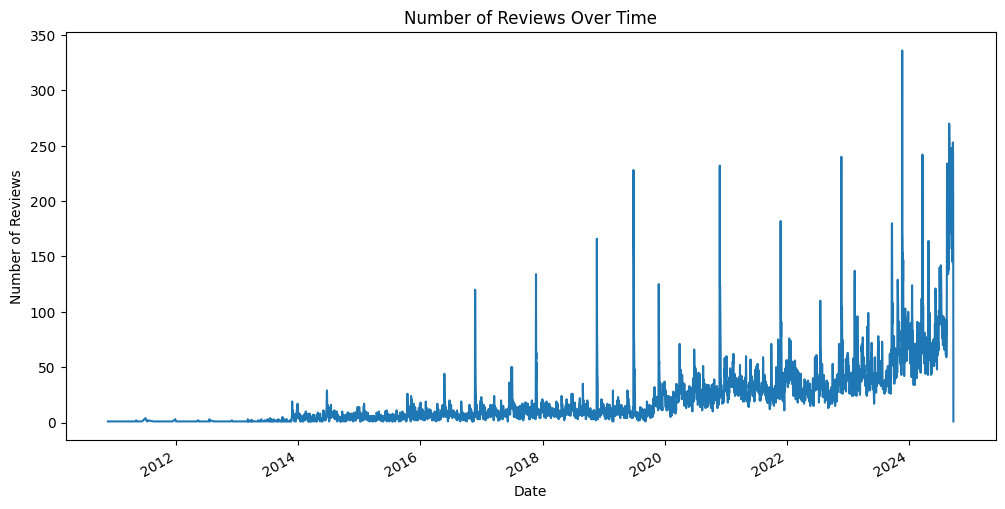

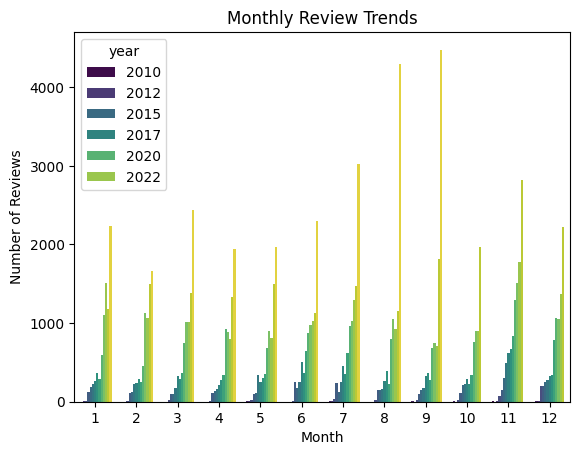

In [19]:
df_sample['date'].value_counts().sort_index().plot(kind='line', figsize=(12, 6))
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.show()

# Extract month or year for additional trends
df_sample['year'] = df_sample['date'].dt.year
df_sample['month'] = df_sample['date'].dt.month

# Monthly trends
sns.countplot(data=df_sample, x='month', hue='year', palette='viridis')
plt.title("Monthly Review Trends")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()

# Feature Engineering

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['processed_review'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"This matrix has {tfidf_matrix.shape[0]} documents (reviews) and {tfidf_matrix.shape[1]} unique features (words).")
print("TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.")


TF-IDF Matrix Shape: (100000, 5000)
This matrix has 100000 documents (reviews) and 5000 unique features (words).
TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.


Make sure the `glove.6B.100d.txt` is in the same folder when running this

In [21]:
glove_embedding_dim = 100
glove_path = 'glove.6B.100d.txt'

In [22]:
def load_glove_embeddings(path):
    embeddings_index = {}
    if not os.path.exists(path):
        print(f"ERROR: GloVe file '{path}' not found.")
        return {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [23]:
embedding_index = load_glove_embeddings(glove_path)

In [24]:
def create_avg_word_embedding(text_tokens_string, embeddings_index, embedding_dim):
    tokens = text_tokens_string.split()
    vectors = []
    for word in tokens:
        if word in embeddings_index:
            vectors.append(embeddings_index[word])
    
    if not vectors:
        return np.zeros(embedding_dim)
    
    return np.mean(vectors, axis=0)

In [ ]:
df_sample['glove_features'] = df_sample['review'].apply(
    lambda x: create_avg_word_embedding(x, embedding_index, glove_embedding_dim).tolist()
)

In [26]:
glove_features_matrix = np.array(df_sample['glove_features'].tolist())

print(f"Shape of GloVe features matrix: {glove_features_matrix.shape}")

Shape of GloVe features matrix: (100000, 100)


In [27]:
class ReviewsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        return item

In [28]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
dataset = ReviewsDataset(df_sample['review'].tolist(), bert_tokenizer, 64)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

The contextual embeddings (BERT embeddings) process, the embeddings is saved to a `.npy` file.

In [31]:
# all_embeddings = []

# with torch.no_grad():
#     for batch in tqdm(dataloader, desc="Extracting Embeddings"):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs =  bert_model(**batch)
#         last_hidden_state = outputs.last_hidden_state
        
#         cls_embeddings = last_hidden_state[:, 0, :] 
#         all_embeddings.append(cls_embeddings.cpu())

In [32]:
# all_embeddings = torch.cat(all_embeddings, dim=0)

In [33]:
# np_embeddings = all_embeddings.numpy()
# np.save("steam_review_embeddings.npy", np_embeddings)

In [34]:
df_sentiment_classification = df_sample.copy()

df_sentiment_classification['recommendation'] = df_sentiment_classification['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)

df_sentiment_classification.drop(columns=['review', 'date', 'game_name', 'username', 'processed_review', 'glove_features'], inplace=True)

df_sentiment_classification.head()

,hours_played,helpful,funny,recommendation,year,month
0,18.1,1.0,1.0,1,2023,7
1,5.2,4.0,0.0,0,2024,2
2,13.0,2.0,0.0,1,2022,11
3,163.4,1.0,0.0,1,2021,11
4,1.4,1.0,0.0,0,2024,4


In [35]:
np_embeddings = np.load("steam_review_embeddings.npy")

In [36]:
bert_feature_df = pd.DataFrame(np_embeddings, columns=[f'bert_dim_{i}' for i in range(np_embeddings.shape[1])])
df_sentiment_classification = pd.concat([df_sentiment_classification, bert_feature_df], axis=1)
print(f"\nBERT embeddings added to the DataFrame. New shape: {df_sentiment_classification.shape}")
print(df_sentiment_classification.head())


BERT embeddings added to the DataFrame. New shape: (100000, 774)
   hours_played  helpful  funny  recommendation  year  month  bert_dim_0  \
0          18.1      1.0    1.0               1  2023      7   -1.229954   
1           5.2      4.0    0.0               0  2024      2   -0.531137   
2          13.0      2.0    0.0               1  2022     11   -1.291901   
3         163.4      1.0    0.0               1  2021     11   -0.022856   
4           1.4      1.0    0.0               0  2024      4    0.024888   

   bert_dim_1  bert_dim_2  bert_dim_3  ...  bert_dim_758  bert_dim_759  \
0   -0.054903    0.262038    0.208959  ...      0.346292     -0.121331   
1   -0.382127    0.473097    0.125252  ...     -0.189234      0.042126   
2   -0.683167    0.621420    0.153559  ...     -0.500190      0.021927   
3   -0.300879    0.411384   -0.032367  ...     -0.478246     -0.539365   
4   -0.143925    0.032354   -0.013994  ...     -0.400059     -0.171364   

   bert_dim_760  bert_dim_761  b

# Modeling


### Traditional Model


In [38]:
rf = RandomForestClassifier(n_estimators = 200 ,random_state=50,  n_jobs=-1)
xgb = XGBClassifier(n_estimators = 200, eval_metric='logloss', random_state=42, n_jobs=-1)

In [39]:
X = df_sentiment_classification.drop('recommendation', axis=1) 
y = df_sentiment_classification['recommendation']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [40]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [42]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Hyperparameter Tuning (Failed)

In [ ]:
# rf_model = RandomForestClassifier(random_state=50)
# xgb_model = XGBClassifier(eval_metric='logloss', random_state=50)

In [46]:
# from scipy.stats import randint

# param_dist_rf = {
#     'n_estimators': randint(100, 500), # Number of trees in the forest
#     'max_features': ['sqrt', 'log2', 0.8, 1.0], # Number of features to consider at each split
#     'max_depth': randint(10, 100), # Maximum depth of the tree
#     'min_samples_split': randint(2, 20), # Minimum number of samples required to split an internal node
#     'min_samples_leaf': randint(1, 20), # Minimum number of samples required to be at a leaf node
#     'bootstrap': [True, False], # Whether bootstrap samples are used when building trees
#     'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
# }

In [47]:
# from sklearn.model_selection import RandomizedSearchCV

# random_search_rf = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_dist_rf,
#     n_iter=50, # Number of iterations for random search
#     cv=5,      
#     scoring='f1', 
#     random_state=42,
#     verbose=1
# )

In [48]:
# from scipy.stats import uniform

# param_dist_xgb = {
#     'n_estimators': randint(100, 1000), # Number of boosting rounds (trees)
#     'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
#     'max_depth': randint(3, 10), # Maximum depth of a tree
#     'subsample': uniform(0.6, 0.4), # Subsample ratio of the training instance
#     'colsample_bytree': uniform(0.6, 0.4), # Subsample ratio of columns when constructing each tree
#     'gamma': uniform(0, 0.5), # Minimum loss reduction required to make a further partition
#     'lambda': uniform(0.5, 1.5), # L2 regularization term on weights
#     'alpha': uniform(0, 0.5) # L1 regularization term on weights
# }

In [49]:
# random_search_xgb = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist_xgb,
#     n_iter=20, # Number of iterations for hyperparameter search
#     cv=5,      
#     scoring='accuracy',
#     random_state=42,
#     verbose=1
# )

In [50]:
# random_search_rf.fit(X_train, y_train)

# print("\nRandom Forest Random Search Results:")
# print(f"Best parameters found: {random_search_rf.best_params_}")
# print(f"Best cross-validation accuracy: {random_search_rf.best_score_:.4f}")

In [ ]:
# random_search_xgb.fit(X_train, y_train)

# print("\n--- Best XGBoost Model Evaluation on Test Set ---")
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
# print("Classification Report:")
# print(classification_report(y_test, y_pred_xgb))

### Deep Learning Model

In [ ]:
df_nn = df_sample.copy()
df_nn.head()

In [ ]:
df_nn['recommendation'] = df_nn['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)
df_nn.head()

In [ ]:
labels = df_nn['recommendation']

np.save("labels.npy", labels)

labels.shape

In [ ]:
X = np.load("steam_review_embeddings.npy")
y = np.load("labels.npy")

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [ ]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
class SentimentNN(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, dropout=0.3):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x)).squeeze(1)

In [ ]:
model = SentimentNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.6f}, Val Loss = {val_losses[-1]:.6f}")
    torch.save(model.state_dict(), f"nn8020/sentiment_nn_8020_epoch_{epoch+1}.pth")

# Model Evaluation

### Traditional Model


In [ ]:
# Random Forest Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_rf)}")

# Random Forest Precision
print(f"Precision: {metrics.precision_score(y_test, y_pred_rf)}")

# Random Forest Recall
print(f"Recall: {metrics.recall_score(y_test, y_pred_rf)}")

# Random Forest F1 Score
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_rf)}")

In [ ]:
# XGBoost Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_xgb)}")

# XGBoost Precision
print(f"Precision: {metrics.precision_score(y_test, y_pred_xgb)}")

# XGBoost Recall
print(f"Recall: {metrics.recall_score(y_test, y_pred_xgb)}")

# XGBoost F1 Score
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_xgb)}")

In [ ]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Not Recommended", "Recommended"])
disp_rf.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
# Confusion Matrix for XGBoost
cm_xg = confusion_matrix(y_test, y_pred_xgb)
disp_xg = ConfusionMatrixDisplay(confusion_matrix=cm_xg, display_labels=["Not Recommended", "Recommended"])
disp_xg.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [ ]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=50)

In [ ]:
# Random Forest cross-validation for accuracy
rf_accuracy = cross_val_score(rf, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
print(f"Random Forest 3-Fold CV Accuracy: {rf_accuracy}")
print(f"Random Forest Mean Accuracy: {rf_accuracy.mean():.4f} (+/- {rf_accuracy.std():.4f})")

# XGBoost cross-validation for accuracy
xgb_accuracy = cross_val_score(xgb, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
print(f"XGBoost 3-Fold CV Accuracy: {xgb_accuracy}")
print(f"XGBoost Mean Accuracy: {xgb_accuracy.mean():.4f} (+/- {xgb_accuracy.std():.4f})")

In [ ]:
# Random Forest cross-validation for precision
rf_precision = cross_val_score(rf, X, y, cv=kfold, scoring='precision', n_jobs=-1)
print(f"Random Forest 3-Fold CV Precision: {rf_precision}")
print(f"Random Forest Mean Precision: {rf_precision.mean():.4f} (+/- {rf_precision.std():.4f})")

# XGBoost cross-validation for precision
xgb_precision = cross_val_score(xgb, X, y, cv=kfold, scoring='precision', n_jobs=-1)
print(f"XGBoost 3-Fold CV Precision: {xgb_precision}")
print(f"XGBoost Mean Precision: {xgb_precision.mean():.4f} (+/- {xgb_precision.std():.4f})")

In [ ]:
# Random Forest cross-validation for recall
rf_recall = cross_val_score(rf, X, y, cv=kfold, scoring='recall', n_jobs=-1)
print(f"Random Forest 3-Fold CV Recall: {rf_recall}")
print(f"Random Forest Mean Recall: {rf_recall.mean():.4f} (+/- {rf_recall.std():.4f})")

# XGBoost cross-validation for recall
xgb_recall = cross_val_score(xgb, X, y, cv=kfold, scoring='recall', n_jobs=-1)
print(f"XGBoost 3-Fold CV Recall: {xgb_recall}")
print(f"XGBoost Mean Recall: {xgb_recall.mean():.4f} (+/- {xgb_recall.std():.4f})")

In [ ]:
# Random Forest cross-validation for F1 score
rf_scores = cross_val_score(rf, X, y, cv=kfold, scoring='f1', n_jobs=-1)
print(f"Random Forest 3-Fold CV F1 Scores: {rf_scores}")
print(f"Random Forest Mean F1: {rf_scores.mean():.4f} (+/- {rf_scores.std():.4f})")

# XGBoost cross-validation for F1 score
xgb_scores = cross_val_score(xgb, X, y, cv=kfold, scoring='f1', n_jobs=-1)
print(f"XGBoost 3-Fold CV F1 Scores: {xgb_scores}")
print(f"XGBoost Mean F1: {xgb_scores.mean():.4f} (+/- {xgb_scores.std():.4f})")

### Deep Learning Model

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch+1")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch in range(1, 100):
    model.load_state_dict(torch.load(f'nn8020/sentiment_nn_8020_epoch_{epoch}.pth'))
    model.eval()

    # Validation accuracy
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())
    val_binary = [1 if p >= 0.5 else 0 for p in val_preds]
    val_accuracies.append(accuracy_score(val_labels, val_binary))

    # Training accuracy
    train_preds, train_labels = [], []
    with torch.no_grad():
        for xb, yb in train_loader:
            preds = model(xb)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(yb.cpu().numpy())
    train_binary = [1 if p >= 0.5 else 0 for p in train_preds]
    train_accuracies.append(accuracy_score(train_labels, train_binary))

# Plot graph
plt.plot(range(1, 100), train_accuracies, label="Train Accuracy", color="blue")
plt.plot(range(1, 100), val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = SentimentNN()
model.load_state_dict(torch.load("nn8020/sentiment_nn_8020_epoch_60.pth"))
model.eval()

# Predict on validation set
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        preds = model(xb)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Binarize predictions
binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

# Metrics
print(f"Accuracy: {metrics.accuracy_score(all_labels, binary_preds)}")
print(f"Precision: {metrics.precision_score(all_labels, binary_preds)}")
print(f"Recall: {metrics.recall_score(all_labels, binary_preds)}")
print(f"F1 Score: {metrics.f1_score(all_labels, binary_preds)}")

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Recommended", "Recommended"])
disp.plot(cmap="Blues")
plt.title("Neural Network Confusion Matrix")
plt.show()

# Sentiment Analysis

In [ ]:
df_sentiment_analysis = df_sample.copy()
df_sentiment_analysis.head()

In [ ]:
df_sentiment_analysis['recommendation'] = df_sentiment_analysis['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)
df_sentiment_analysis.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_sentiment_analysis['processed_review'], df_sentiment_analysis['recommendation'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_vec, y_train)

In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_vec, y_train)

In [ ]:
from sklearn.metrics import classification_report
preds_rf = model_rf.predict(X_test_vec)
preds_xgb = model_xgb.predict(X_test_vec)
print("Random Forest:\n", classification_report(y_test, preds_rf))
print("XGBoost:\n", classification_report(y_test, preds_xgb))

### Deep Learning - BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
df_sentiment_analysis = df_sample.copy()
df_sentiment_analysis.head()

In [ ]:
# pytorch dataset for easy batching

class ReviewsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        return item

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

In [ ]:
dataset = ReviewsDataset(df_sentiment_analysis['processed_review'].tolist(), tokenizer)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
all_predictions = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Processing Batches"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())

In [ ]:
# Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# True labels
df_sentiment_analysis['recommendation'] = df_sentiment_analysis['recommendation'].apply(lambda x: 1 if x == 'Recommended' else 0)
true_labels = df_sentiment_analysis['recommendation'].values

# Predicted labels
predicted_labels = all_predictions

# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall:    {recall:.6f}")
print(f"F1 Score:  {f1:.6f}")

In [ ]:
df_sentiment_analysis['predicted_sentiment'] = all_predictions
df_sentiment_analysis.to_csv("steam_reviews_with_sentiment.csv", index=False)

### Opinion Mining

In [ ]:
df_sample_opinion_absa[['review', 'processed_review']].sample(5)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_opinions(text):
    doc = nlp(text)
    opinions = []
    for token in doc:
        if token.dep_ == "amod" and token.head.pos_ == "NOUN":
            opinions.append((token.text, token.head.text))  
    return opinions

In [ ]:
from nltk.corpus import sentiwordnet as swn

def get_sentiment_score(word):
    try:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            s = synsets[0]
            return s.pos_score() - s.neg_score()
        else:
            return 0.0
    except:
        return 0.0

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english", 
    truncation=True,
    framework="pt"
)

def safe_sentiment(review):
    if len(review.split()) > 500:
        review = " ".join(review.split()[:500])
    result = sentiment_pipeline(review)[0]
    return result['label']

In [ ]:
tqdm.pandas()

df_sample_opinion_absa['explicit_opinions'] = df_sample_opinion_absa['processed_review'].apply(extract_opinions)
df_sample_opinion_absa['explicit_sentiment_score'] = df_sample_opinion_absa['explicit_opinions'].apply(
    lambda pairs: sum([get_sentiment_score(op[0]) for op in pairs]) / len(pairs) if pairs else 0
)
df_sample_opinion_absa['implicit_sentiment'] = df_sample_opinion_absa['review'].apply(safe_sentiment)

In [ ]:
def compare_sentiments(row):
    if row['explicit_sentiment_score'] > 0.1 and row['implicit_sentiment'] == "NEGATIVE":
        return 'Conflict: Explicit Positive, Implicit Negative'
    elif row['explicit_sentiment_score'] < -0.1 and row['implicit_sentiment'] == "POSITIVE":
        return 'Conflict: Explicit Negative, Implicit Positive'
    else:
        return 'Aligned'

df_sample_opinion_absa['sentiment_alignment'] = df_sample_opinion_absa.apply(compare_sentiments, axis=1)

In [ ]:
df_sample_opinion_absa[['explicit_opinions','explicit_sentiment_score','implicit_sentiment','sentiment_alignment']]

In [ ]:
from collections import Counter
from itertools import chain

all_targets = list(chain.from_iterable([ [target for _, target in pair] for pair in df_sample_opinion_absa['explicit_opinions']]))
target_counts = Counter(all_targets)
print(target_counts.most_common(10))

In [ ]:
top_targets = target_counts.most_common(10)
top_targets_df = pd.DataFrame(top_targets, columns=['opinion_target', 'count'])

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x='implicit_sentiment', data=df_sample_opinion_absa, palette='viridis', order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.title('Distribution of Overall (Implicit) Review Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
alignment_counts = df_sample_opinion_absa['sentiment_alignment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(alignment_counts, labels=alignment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm'))
plt.title('Proportion of Sentiment Alignment Categories')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='opinion_target', data=top_targets_df, palette='cubehelix')
plt.title(f'Top 10 Most Frequently Mentioned Aspects')
plt.xlabel('Count')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

### Aspect-Based Sentiment Analysis (ABSA)

In [ ]:
def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text.split()) <= 3]

In [ ]:
def get_sentiment_score(word):
    try:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            s = synsets[0]
            return s.pos_score() - s.neg_score()
    except:
        return 0.0
    return 0.0

In [ ]:
def extract_aspect_sentiment(text):
    doc = nlp(text)
    aspect_sentiment_pairs = []
    for token in doc:
        if token.dep_ == "amod" and token.head.pos_ == "NOUN":
            sentiment_score = get_sentiment_score(token.text)
            sentiment_label = "positive" if sentiment_score > 0.1 else "negative" if sentiment_score < -0.1 else "neutral"
            aspect_sentiment_pairs.append((token.head.text.lower(), sentiment_label))
    return aspect_sentiment_pairs

In [ ]:
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
absa_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, max_length=512)

In [ ]:
def transformer_absa(text):
    aspects = extract_aspects(text)
    results = []
    for asp in aspects:
        try:
            formatted_text = f"{text} [ASP] {asp} [ASP]"
            prediction = absa_pipeline(formatted_text)[0]
            results.append({
                'aspect': asp,
                'sentiment': prediction['label'],
                'confidence': round(prediction['score'], 3)
            })
        except:
            continue
    return results

In [ ]:
tqdm.pandas()

df_sample_opinion_absa['aspects'] = df_sample_opinion_absa['processed_review'].progress_apply(extract_aspects)
df_sample_opinion_absa['aspect_sentiment_rule'] = df_sample_opinion_absa['processed_review'].progress_apply(extract_aspect_sentiment)
df_sample_opinion_absa['aspect_sentiment_transformer'] = df_sample_opinion_absa['processed_review'].progress_apply(transformer_absa)

In [ ]:
df_sample_opinion_absa[['aspects','aspect_sentiment_rule','aspect_sentiment_transformer']]

In [ ]:
from ast import literal_eval
# Convert stringified lists to actual lists if needed
df_sample_opinion_absa['aspect_sentiment_rule'] = df_sample_opinion_absa['aspect_sentiment_rule'].apply(literal_eval)
df_sample_opinion_absa['aspect_sentiment_transformer'] = df_sample_opinion_absa['aspect_sentiment_transformer'].apply(literal_eval)

# Extract sentiments
def extract_sentiments(sentiment_data, is_dict=False):
    sentiments = []
    for entry in sentiment_data:
        if is_dict:
            sentiments.append(entry['sentiment'].lower())
        else:
            sentiments.append(entry[1].lower())
    return sentiments

# Flatten and count
rule_sentiments = df_sample_opinion_absa['aspect_sentiment_rule'].apply(extract_sentiments)
transformer_sentiments = df_sample_opinion_absa['aspect_sentiment_transformer'].apply(lambda x: extract_sentiments(x, is_dict=True))

# Flatten
flat_rule = [s for sublist in rule_sentiments for s in sublist]
flat_transformer = [s for sublist in transformer_sentiments for s in sublist]

# Count and make DataFrame
rule_counts = pd.Series(flat_rule).value_counts().rename_axis('Sentiment').reset_index(name='Count')
rule_counts['Method'] = 'Rule-based'

transformer_counts = pd.Series(flat_transformer).value_counts().rename_axis('Sentiment').reset_index(name='Count')
transformer_counts['Method'] = 'Transformer-based'

combined_counts = pd.concat([rule_counts, transformer_counts])

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=combined_counts, x='Sentiment', y='Count', hue='Method')
plt.title("Sentiment Counts: Rule-based vs Transformer-based ABSA")
plt.ylabel("Number of Aspects")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
aspect_sentiments = []

for row in df_sample_opinion_absa['aspect_sentiment_transformer']:
    for item in row:
        aspect_sentiments.append((item['aspect'], item['sentiment']))

df_absa = pd.DataFrame(aspect_sentiments, columns=['aspect', 'sentiment'])
top_aspects = df_absa['aspect'].value_counts().head(10).index
filtered = df_absa[df_absa['aspect'].isin(top_aspects)]

plt.figure(figsize=(10, 5))
sns.countplot(data=filtered, x='aspect', hue='sentiment')
plt.title('Sentiment Distribution for Top Aspects using Transformer ABSA')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

In [ ]:
aspect_sentiments = []

for row in df_sample_opinion_absa['aspect_sentiment_rule']:
    for item in row:
        aspect_sentiments.append((item[0], item[1]))

df_absa = pd.DataFrame(aspect_sentiments, columns=['aspect', 'sentiment'])
top_aspects = df_absa['aspect'].value_counts().head(10).index
filtered = df_absa[df_absa['aspect'].isin(top_aspects)]

plt.figure(figsize=(10, 5))
sns.countplot(data=filtered, x='aspect', hue='sentiment')
plt.title('Sentiment Distribution for Top Aspects Using Rule-Based ABSA')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

In [ ]:
%pip install matplotlib-venn

from matplotlib_venn import venn2
rule_ids = set(df_sample_opinion_absa[df_sample_opinion_absa['aspect_sentiment_rule'].apply(lambda x: len(x) > 0)].index)
transformer_ids = set(df_sample_opinion_absa[df_sample_opinion_absa['aspect_sentiment_transformer'].apply(lambda x: len(x) > 0)].index)

# Plot Venn Diagram
plt.figure(figsize=(6,6))
venn2([rule_ids, transformer_ids], set_labels=('Rule-based ABSA', 'Transformer-based ABSA'))
plt.title("Overlap of Reviews with Aspect Sentiments\n(Rule vs Transformer Method)")
plt.show()